In [31]:
# Updated March 21, 2025

In [32]:
#  import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [33]:
file_path = os.path.join("data", "diabetes_prediction_dataset.csv")
df = pd.read_csv(file_path)
# df = pd.read_csv("C:/Users/USSB697670/Desktop/GeorgiaTech/Data_Visual_Analytics/Project/diabetes_prediction_dataset.csv")

print(f"Dataset Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")


df.head()

Dataset Shape: (100000, 9)
Missing Values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Duplicate Rows: 3854


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


**check for duplicates**

In [34]:
duplicate_rows = df[df.duplicated()]
display(duplicate_rows.head(10))
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dataset Shape After Removing Duplicates: {df.shape}")


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0
4106,Female,51.0,0,0,No Info,27.32,6.6,200,0
4128,Female,80.0,0,0,never,27.32,5.7,85,0
4224,Male,80.0,1,0,former,27.32,6.2,130,0
4263,Male,80.0,0,0,No Info,27.32,6.0,100,0
4486,Male,50.0,0,0,No Info,27.32,4.8,155,0


Dataset Shape After Removing Duplicates: (96146, 9)


# Exploratory Data Analysis

Checking missing value

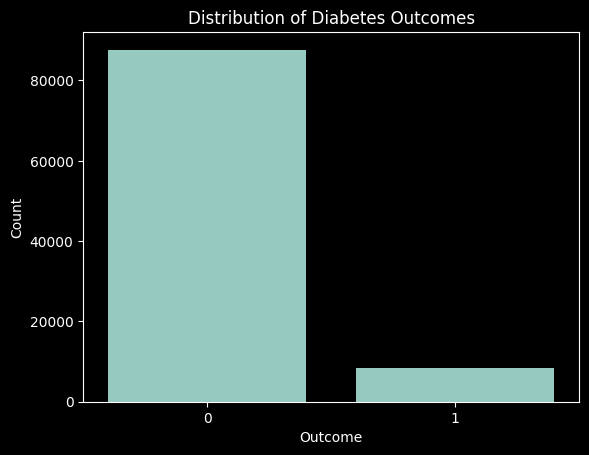

In [35]:
# print(df.isnull().sum())
sns.countplot(x=df['diabetes'], data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Label Encoder

**Review the categorical variables**
 - **if needed, we will use label encoding**

In [36]:
# Check unique values for 'gender'
print("Unique values in 'gender':", df['gender'].unique())

# Check unique values for 'smoking_history'
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'gender': ['Female' 'Male' 'Other']
Unique values in 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']


**Since Gender has 3 values, we can keep the Label encoding as-is**
**However, smoking_history has 6 values, so we will use one-hot encoding**


In [37]:
# Encode 'gender'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])


**Encoding smoking_history for RandomForest**

In [38]:
# Encode 'smoking_history' using LabelEncoder
# df_original = pd.read_csv(file_path)
# Restore 'smoking_history' if missing
if 'smoking_history' not in df.columns:
    df_original = pd.read_csv(file_path)  # Load fresh dataset
    df['smoking_history'] = df_original['smoking_history']

le_smoking = LabelEncoder()
df['smoking_history_encoded'] = le_smoking.fit_transform(df['smoking_history'])

# Use encoded version
selected_features_random_forest = ["HbA1c_level", "blood_glucose_level", "bmi", "age", 
                                   "hypertension", "heart_disease", "smoking_history_encoded"]

# Create a separate DataFrame for Random Forest modeling
df_random_forest = df[selected_features_random_forest + ["diabetes"]]

**Encoding smoking_history for all models except RandomForest**

In [39]:
# Implementing Target Encoding for 'smoking_history'
# Assuming the dataset contains a binary target variable 'diabetes'

# Calculate mean diabetes rate per smoking category (Target Encoding)
df['smoking_encoded'] = df.groupby('smoking_history')['diabetes'].transform('mean')

# Drop original smoking_history columns after target encoding
df.drop(columns=[col for col in df.columns if 'smoking_history' in col], inplace=True)

# Display updated column names after encoding
print("Updated Columns after Encoding:", df.columns)

# Display first few rows to verify encoding
display(df.head())

Updated Columns after Encoding: Index(['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_encoded'],
      dtype='object')


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,0,80.0,0,1,25.19,6.6,140,0,0.097011
1,0,54.0,0,0,27.32,6.6,80,0,0.043938
2,1,28.0,0,0,27.32,5.7,158,0,0.097011
3,0,36.0,0,0,23.45,5.0,155,0,0.103077
4,1,76.0,1,1,20.14,4.8,155,0,0.103077


In [40]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,0,80.0,0,1,25.19,6.6,140,0,0.097011
1,0,54.0,0,0,27.32,6.6,80,0,0.043938
2,1,28.0,0,0,27.32,5.7,158,0,0.097011
3,0,36.0,0,0,23.45,5.0,155,0,0.103077
4,1,76.0,1,1,20.14,4.8,155,0,0.103077
...,...,...,...,...,...,...,...,...,...
96141,0,36.0,0,0,24.60,4.8,145,0,0.043938
96142,0,2.0,0,0,17.37,6.5,100,0,0.043938
96143,1,66.0,0,0,27.83,5.7,155,0,0.170986
96144,0,24.0,0,0,35.42,4.0,100,0,0.097011


In [41]:
import sqlite3

# Connect to SQLite database (creates if it doesn’t exist)
conn = sqlite3.connect("diabetes_results.db")
cursor = conn.cursor()

# Drop the existing table (WARNING: This will delete all previous results)
cursor.execute("DROP TABLE IF EXISTS model_results")


# Create table for storing model results
cursor.execute("""
    CREATE TABLE IF NOT EXISTS model_results (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        model_name TEXT,
        data_type TEXT,
        threshold REAL,
        precision REAL,
        recall REAL,
        f1_score REAL,
        accuracy REAL,
        run_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
""")
conn.commit()
conn.close()


In [42]:
import sqlite3
from sklearn.metrics import classification_report

def store_classification_results(model_name, data_type, threshold, y_true, y_pred):
    """Extract classification metrics and store them in SQLite"""
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Extract key metrics
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1_score = report["1"]["f1-score"]
    accuracy = report["accuracy"]
    
    # Store in SQLite database
    conn = sqlite3.connect("diabetes_results.db")
    cursor = conn.cursor()

    # Check if this model run already exists
    cursor.execute("""
        SELECT COUNT(*) FROM model_results
        WHERE model_name = ? AND data_type = ? AND threshold = ? AND precision = ? AND recall = ? AND accuracy = ?
    """, (model_name, data_type, threshold, precision, recall, accuracy))

    cursor.execute("""
        INSERT INTO model_results (model_name, data_type, threshold, precision, recall, f1_score, accuracy)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (model_name, data_type, threshold, precision, recall, f1_score, accuracy))
    
    conn.commit()
    conn.close()
    
    print(f"Results stored successfully: {model_name} (Threshold: {threshold})")



# Feature Importance

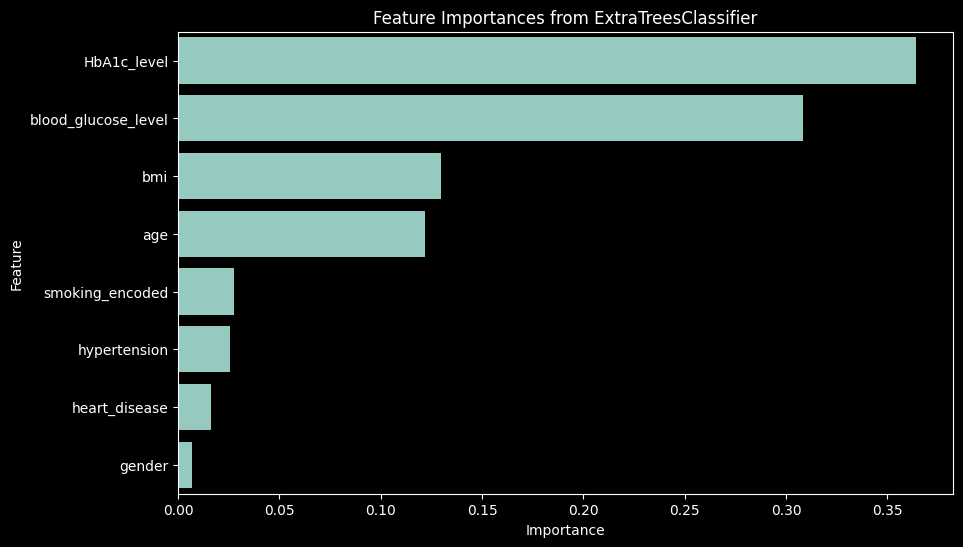

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

# Define Features and Target variables
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Train ExtraTreesClassifier to identify feature importance
model = ExtraTreesClassifier()
model.fit(X, y)
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the DataFrame by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances from ExtraTreesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Feature Selection**

In [44]:
# Keep all features for visualization & dashboard interaction
X_full = df.drop(columns=["diabetes"])  # Keeps everything except the target variable

# Optimized feature set (for model training)
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease", "smoking_encoded"]
X_selected = df[selected_features]

# Target variable remains the same
y = df["diabetes"]


Splitting Data


In [45]:
# We use StratifiedFold so that each fold in x-validation has the same proportion of diabetic and non-diabetic cases as the original dataset. 
# Also ensure balanced class distribution in each fold.
# Also find the best parameters while preventing overfitting
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]



# Model Selection

1. Logistic Regression

In [46]:
# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# # Define features and target
# X = df.drop(columns=["diabetes"])  # Ensure "diabetes" is the correct target column name
# y = df["diabetes"]

# Apply StandardScaler BEFORE train-test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  

# Step 1. Split the data into training and testing sets (80% train, 20% test)

# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=selected_features)  # Ensure you have the correct feature names

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=selected_features)



# # Initialize and train the model
# model = LogisticRegression()
# model.fit(X_train, y_train)

In [47]:
# Step 2. Use only selected features for model training
#selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 3. Train the model with selected features
model_lr = LogisticRegression()
model_lr.fit(X_train_selected, y_train)

# Step 4: Evaluate and make predictions on test set
y_preds_test_lr = model_lr.predict(X_test_selected)
store_classification_results("Logistic Regression", "test", 0.50, y_test, y_preds_test_lr)

# Step 5: Evaluate and make predictions on train set
y_preds_train_lr = model_lr.predict(X_train_selected)
store_classification_results("Logistic Regression", "train", 0.50, y_train, y_preds_train_lr)

print("Model Performance on Test set with Selected Features:")
print(classification_report(y_test, y_preds_test_lr))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_lr))

print("Model Performance on Train set with Selected Features:")
print(classification_report(y_train, y_preds_train_lr))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_lr))


Results stored successfully: Logistic Regression (Threshold: 0.5)
Results stored successfully: Logistic Regression (Threshold: 0.5)
Model Performance on Test set with Selected Features:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17532
           1       0.85      0.63      0.73      1697

    accuracy                           0.96     19229
   macro avg       0.91      0.81      0.85     19229
weighted avg       0.96      0.96      0.96     19229

Confusion Matrix (Test Set):
[[17349   183]
 [  625  1072]]
Model Performance on Train set with Selected Features:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     70132
           1       0.87      0.63      0.73      6785

    accuracy                           0.96     76917
   macro avg       0.92      0.81      0.85     76917
weighted avg       0.96      0.96      0.96     76917

Confusion Matrix (Train Set):
[[69478   654]


**Summary**
    - **Model Accuracy is at 96%**  
    - **When the model predicts diabetes, it is correct 86% of the time**    
    - **However, the model only catches 64% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.73**   

**Concerns**    
    - **We are missing 36% of the actual diabetic cases**   

Check class distribution

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


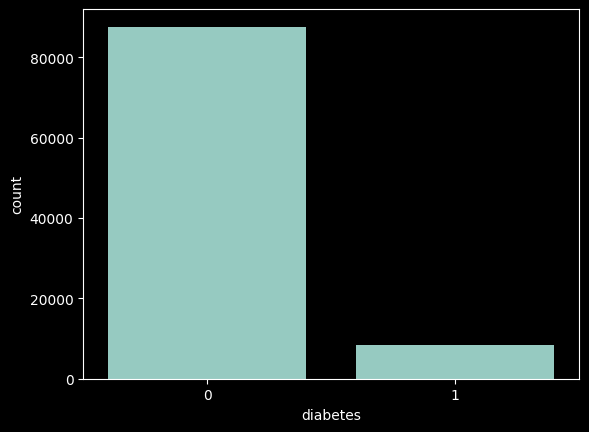

In [48]:
import seaborn as sns

sns.countplot(x=y)
print(y.value_counts(normalize=True))  # Shows class proportions


Handling class imbalance as the Model is predicting majority as 0 meaning "no diabetes"


**Test SMOTE with  default threshold 0.50**

In [49]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Train Logistic Regression Again
model_smote = LogisticRegression()
model_smote.fit(X_train_balanced, y_train_balanced)

# # Predict & Evaluate
# y_preds_smote = model_smote.predict(X_test_selected)
# store_classification_results("Logistic Regression (SMOTE)", 0.50, y_test, y_preds_smote)
# print("Model Performance after SMOTE:")
# print(classification_report(y_test, y_preds_smote))

# Step 4: Evaluate and make predictions on test set
y_preds_test_smote = model_smote.predict(X_test_selected)
store_classification_results("Logistic Regression (SMOTE)", "test", 0.50, y_test, y_preds_test_smote)

# Step 5: Evaluate and make predictions on train set
y_preds_train_smote = model_smote.predict(X_train_selected)
store_classification_results("Logistic Regression (SMOTE)", "train", 0.50, y_train, y_preds_train_smote)

print("Model Performance on Test set with Selected Features:")
print(classification_report(y_test, y_preds_test_smote))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_smote))

print("Model Performance on Train set with Selected Features:")
print(classification_report(y_train, y_preds_train_smote))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_smote))


Results stored successfully: Logistic Regression (SMOTE) (Threshold: 0.5)
Results stored successfully: Logistic Regression (SMOTE) (Threshold: 0.5)
Model Performance on Test set with Selected Features:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     17532
           1       0.52      0.80      0.63      1697

    accuracy                           0.92     19229
   macro avg       0.75      0.86      0.79     19229
weighted avg       0.94      0.92      0.92     19229

Confusion Matrix (Test Set):
[[16274  1258]
 [  341  1356]]
Model Performance on Train set with Selected Features:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     70132
           1       0.53      0.79      0.64      6785

    accuracy                           0.92     76917
   macro avg       0.76      0.86      0.80     76917
weighted avg       0.94      0.92      0.93     76917

Confusion Matrix (Train Set):

**Summary of Model performance after applying SMOTE**
    - **Model Accuracy dropped to 92%**  
    - **When the model predicts diabetes, it is correct 53% of the time**    
    - **However, the model now catches 80% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.64**   

**We are now only missing 20% of the actual diabetic cases**   

In [50]:
import xgboost
print(xgboost.__version__)  # Should be >= 1.3.0


3.0.0


[0]	train-logloss:0.66813	eval-logloss:0.66856
[1]	train-logloss:0.65344	eval-logloss:0.65443
[2]	train-logloss:0.63104	eval-logloss:0.63230
[3]	train-logloss:0.62033	eval-logloss:0.62203
[4]	train-logloss:0.60919	eval-logloss:0.61136
[5]	train-logloss:0.60035	eval-logloss:0.60296
[6]	train-logloss:0.58265	eval-logloss:0.58546
[7]	train-logloss:0.56380	eval-logloss:0.56692
[8]	train-logloss:0.54482	eval-logloss:0.54849
[9]	train-logloss:0.52793	eval-logloss:0.53214
[10]	train-logloss:0.51192	eval-logloss:0.51663
[11]	train-logloss:0.49793	eval-logloss:0.50280
[12]	train-logloss:0.47929	eval-logloss:0.48430
[13]	train-logloss:0.46221	eval-logloss:0.46736
[14]	train-logloss:0.44996	eval-logloss:0.45552
[15]	train-logloss:0.43847	eval-logloss:0.44441
[16]	train-logloss:0.42786	eval-logloss:0.43412
[17]	train-logloss:0.41857	eval-logloss:0.42489
[18]	train-logloss:0.40945	eval-logloss:0.41606
[19]	train-logloss:0.40142	eval-logloss:0.40804
[20]	train-logloss:0.39367	eval-logloss:0.40035
[2

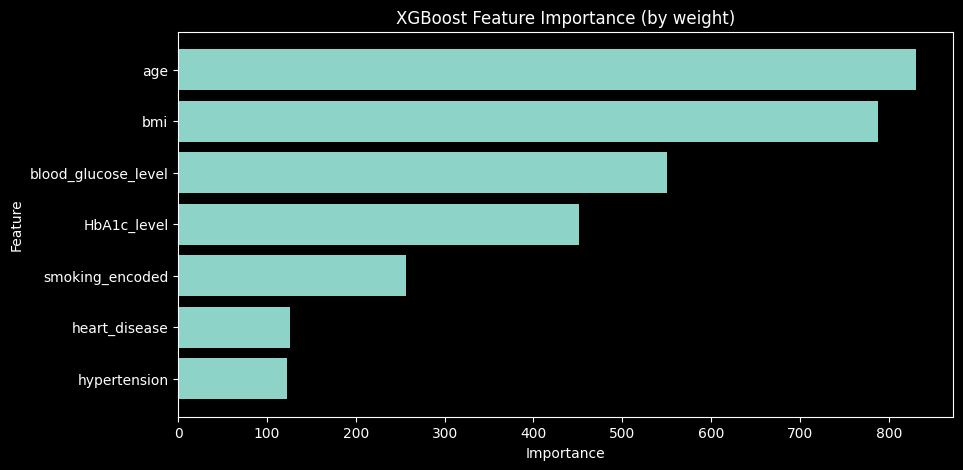

100%|===================| 19202/19229 [05:43<00:00]        

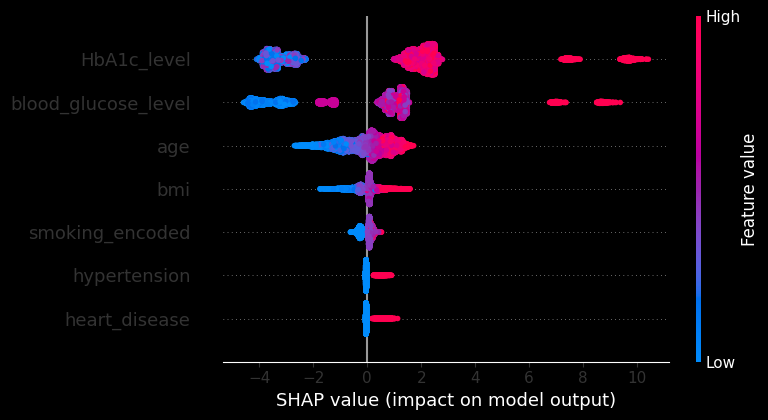


SHAP Feature Importance Ranking:
               Feature  Mean SHAP Value
0          HbA1c_level         2.773728
1  blood_glucose_level         2.057652
3                  age         0.678507
2                  bmi         0.302745
6      smoking_encoded         0.177879
4         hypertension         0.077269
5        heart_disease         0.057661


In [51]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare DMatrix for XGBoost low-level API
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)

# Compute class weight ratio
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'min_child_weight': 3,
    'seed': 42
}

# Train model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Predict test and train
y_preds_test = bst.predict(dtest)
y_preds_test_labels = (y_preds_test >= 0.50).astype(int)

y_preds_train = bst.predict(dtrain)
y_preds_train_labels = (y_preds_train >= 0.50).astype(int)

# Store classification results
store_classification_results("XGBoost (Default threshold 50)", "test", 0.50, y_test, y_preds_test_labels)
store_classification_results("XGBoost (Default threshold 50)", "train", 0.50, y_train, y_preds_train_labels)

# Compute AUC-ROC
roc_auc_test = roc_auc_score(y_test, y_preds_test)
roc_auc_train = roc_auc_score(y_train, y_preds_train)
print(f"Test AUC-ROC: {roc_auc_test:.4f}")
print(f"Train AUC-ROC: {roc_auc_train:.4f}")

# Print classification metrics
print("\nModel Performance on Test set:")
print(classification_report(y_test, y_preds_test_labels))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_labels))

print("\nModel Performance on Train set:")
print(classification_report(y_train, y_preds_train_labels))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_labels))

# Plot built-in feature importances (from booster)
importance_dict = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("XGBoost Feature Importance (by weight)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# SHAP Explanation (note: requires passing raw DataFrame, not DMatrix)
explainer = shap.Explainer(bst, X_test_selected)
shap_values = explainer(X_test_selected)

shap.summary_plot(shap_values, X_test_selected)

# SHAP ranking
shap_importance = pd.DataFrame({
    "Feature": X_test_selected.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values("Mean SHAP Value", ascending=False)

print("\nSHAP Feature Importance Ranking:")
print(shap_importance)


**SHAP Summary**
- **Higher HBA1c & blood glucose level indicate higher diabetes risk**
- **low smoking_encoded, hypertension, and heartdisease reduce diabetes risk**

**Random Forest**

Feature Engineering Applied: BMI × Age interaction, Age bins added.
Stratified K-Fold ROC AUC Scores: [0.9729315  0.97654577 0.97361052 0.97534353 0.97745596]
Average ROC AUC: 0.9752

RANDOM FOREST - TRAIN SET EVALUATION:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     70130
           1       0.44      0.93      0.60      6786

    accuracy                           0.89     76916
   macro avg       0.72      0.91      0.77     76916
weighted avg       0.94      0.89      0.91     76916

Confusion Matrix:
 [[62153  7977]
 [  479  6307]]
ROC AUC Score: 0.9766
Results stored successfully: Random Forest (Threshold: 0.5)

RANDOM FOREST - TEST SET EVALUATION:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     17534
           1       0.43      0.92      0.58      1696

    accuracy                           0.88     19230
   macro avg       0.71      0.90      0.76     19230
weighted 

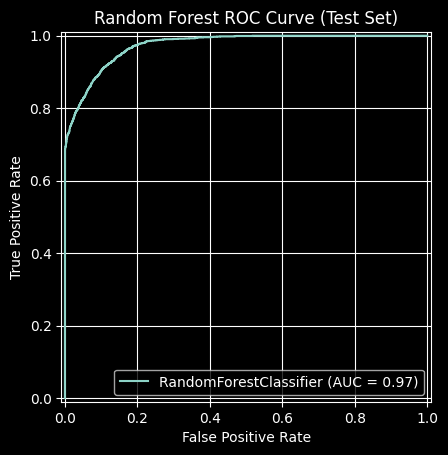

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt

# ======== APPLY FEATURE ENGINEERING BEFORE CROSS-VALIDATION ========
df_random_forest = df_random_forest.copy()  # Avoid modifying original dataset
df_random_forest["bmi_age_interaction"] = df_random_forest["bmi"] * df_random_forest["age"]
df_random_forest["age_bins"] = pd.cut(df_random_forest["age"], bins=[0, 30, 50, 70, 100], labels=[1, 2, 3, 4]).astype(int)

print("Feature Engineering Applied: BMI × Age interaction, Age bins added.")

# ======== DEFINE FEATURES & TARGET =======
#X = df_random_forest.drop(columns=["diabetes", "bmi_age_interaction"])  # Avoid duplicate interaction feature
X = df_random_forest.drop(columns=["diabetes"])  # Avoid duplicate interaction feature
y = df_random_forest["diabetes"]

# ======== TRAIN-TEST SPLIT ========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======== STRATIFIED K-FOLD CROSS-VALIDATION (ON TRAINING DATA ONLY) ========
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=8,  # Limit tree depth
    min_samples_split=10,  # Reduce overfitting
    max_leaf_nodes=50,  # Limit number of leaf nodes
    class_weight='balanced', 
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(f'Stratified K-Fold ROC AUC Scores: {cv_scores}')
print(f'Average ROC AUC: {cv_scores.mean():.4f}')

# ======== TRAIN RANDOM FOREST MODEL ========
rf_model.fit(X_train, y_train)

# Predict on train and test
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# ========== TRAIN EVALUATION ==========
print("\nRANDOM FOREST - TRAIN SET EVALUATION:")
print(classification_report(y_train, y_train_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_train, y_train_proba_rf):.4f}")
store_classification_results("Random Forest", "train", 0.50, y_train, y_train_pred_rf)

# ========== TEST EVALUATION ==========
print("\nRANDOM FOREST - TEST SET EVALUATION:")
print(classification_report(y_test, y_test_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_proba_rf):.4f}")
store_classification_results("Random Forest", "test", 0.50, y_test, y_test_pred_rf)

# ========== ROC Curve ==========
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Random Forest ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


# **TESTING**
 - **Include all unit testing below**


In [53]:
df.describe

<bound method NDFrame.describe of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
96141       0  36.0             0              0  24.60          4.8   
96142       0   2.0             0              0  17.37          6.5   
96143       1  66.0             0              0  27.83          5.7   
96144       0  24.0             0              0  35.42          4.0   
96145       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  
0                      140         0         

In [54]:
df.info

<bound method DataFrame.info of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
96141       0  36.0             0              0  24.60          4.8   
96142       0   2.0             0              0  17.37          6.5   
96143       1  66.0             0              0  27.83          5.7   
96144       0  24.0             0              0  35.42          4.0   
96145       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  
0                      140         0         0.

In [55]:
import pandas as pd

# Load stored results into a DataFrame
conn = sqlite3.connect("diabetes_results.db")
df_results = pd.read_sql("SELECT * FROM model_results", conn)
conn.close()

# Display results
print(df_results)


   id                      model_name data_type  threshold  precision  \
0   1             Logistic Regression      test        0.5   0.854183   
1   2             Logistic Regression     train        0.5   0.867262   
2   3     Logistic Regression (SMOTE)      test        0.5   0.518745   
3   4     Logistic Regression (SMOTE)     train        0.5   0.534495   
4   5  XGBoost (Default threshold 50)      test        0.5   0.454912   
5   6  XGBoost (Default threshold 50)     train        0.5   0.479961   
6   7                   Random Forest     train        0.5   0.441543   
7   8                   Random Forest      test        0.5   0.426699   

     recall  f1_score  accuracy        run_timestamp  
0  0.631703  0.726287  0.957980  2025-03-21 06:42:17  
1  0.629772  0.729679  0.958839  2025-03-21 06:42:17  
2  0.799057  0.629088  0.916844  2025-03-21 06:42:31  
3  0.786735  0.636537  0.920746  2025-03-21 06:42:31  
4  0.930466  0.611068  0.895470  2025-03-21 06:43:12  
5  0.933677 

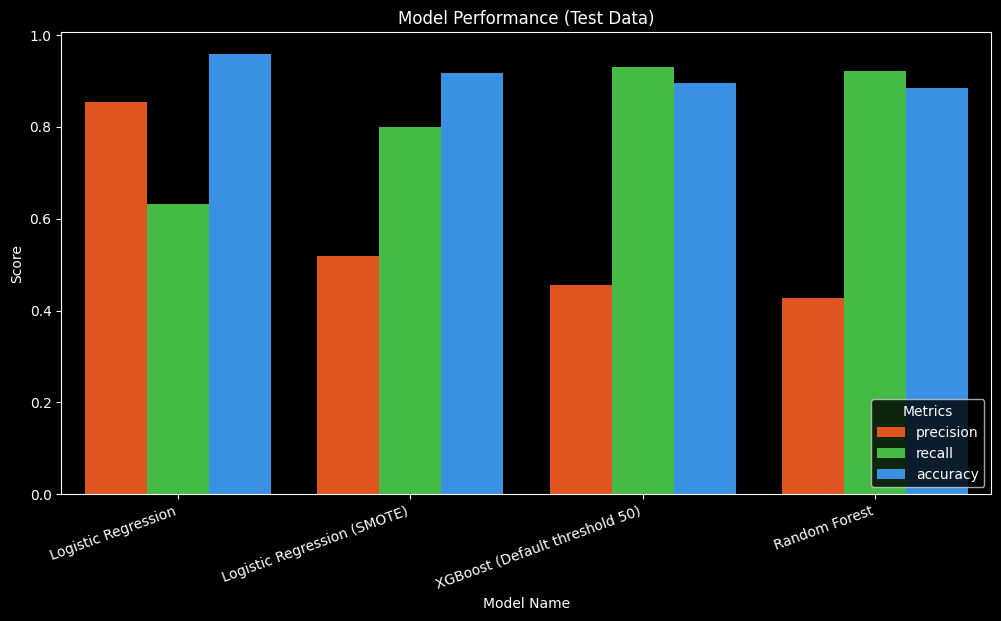

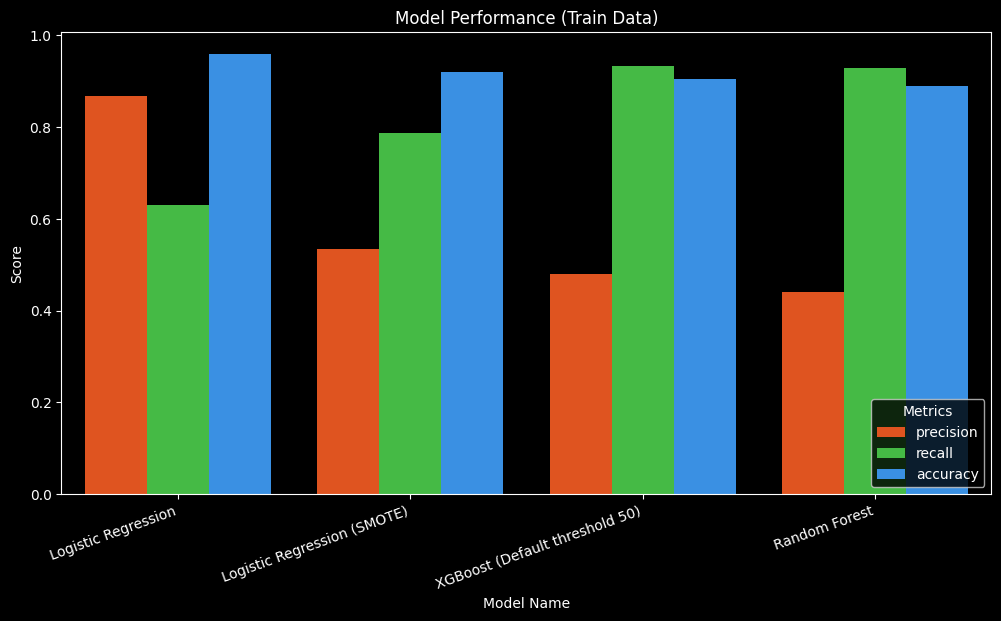

In [56]:
# Re-import necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load stored results into separate DataFrames for test and train
conn = sqlite3.connect("diabetes_results.db")
df_results_test = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'test'", conn)
df_results_train = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'train'", conn)
conn.close()

# Set dark plot style
plt.style.use("dark_background")

# Define brighter colors explicitly
palette = {"precision": "#FF4500", "recall": "#32CD32", "accuracy": "#1E90FF"}

# Function to plot metrics for test and train data separately
def plot_metrics(df, title):
    plt.figure(figsize=(12, 6))
    
    # Reshape DataFrame for seaborn compatibility
    df_melted = df.melt(id_vars='model_name', value_vars=['precision', 'recall', 'accuracy'],
                        var_name='metric', value_name='score')
    
    sns.barplot(data=df_melted, x="model_name", y="score", hue="metric", palette=palette)
    
    # Customize the plot
    plt.xlabel("Model Name")
    plt.ylabel("Score")
    plt.xticks(rotation=20, ha="right")
    plt.title(title)
    plt.legend(title='Metrics', loc='lower right')

    # Show plot
    plt.show()

# Generate separate plots for Test and Train
plot_metrics(df_results_test, "Model Performance (Test Data)")
plot_metrics(df_results_train, "Model Performance (Train Data)")


**Legend**  
    -   **precision: higher the precision, the fewer the false alarms**     
    -   **recall: higher the recall, the model accurately identifies who are diabetic**    

**Line plot for accuracy over Time**

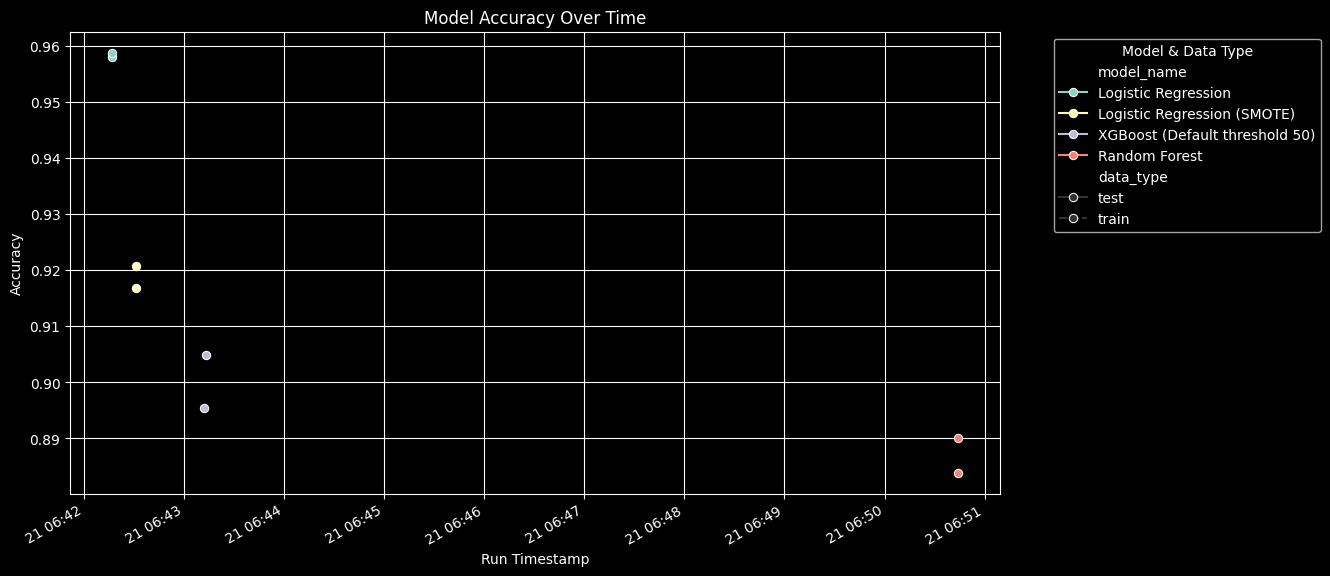

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp to datetime
df_results['run_timestamp'] = pd.to_datetime(df_results['run_timestamp'])

# Sort by timestamp
df_results = df_results.sort_values(by='run_timestamp')

# Plot accuracy over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x="run_timestamp", y="accuracy", hue="model_name", style="data_type", marker="o")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Run Timestamp")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Time")
plt.legend(title="Model & Data Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


**Overfitting Analysis**

In [58]:
df_results_pivot = df_results.pivot(index=["model_name", "threshold"], columns="data_type", values="accuracy")
df_results_pivot["overfitting_score"] = df_results_pivot["train"] - df_results_pivot["test"]

# Display models with the highest overfitting scores
df_results_pivot.sort_values(by="overfitting_score", ascending=False)


,data_type,test,train,overfitting_score
model_name,threshold,,,
XGBoost (Default threshold 50),0.5,0.895470,0.904910,0.009440
Random Forest,0.5,0.883879,0.890062,0.006183
Logistic Regression (SMOTE),0.5,0.916844,0.920746,0.003901
Logistic Regression,0.5,0.957980,0.958839,0.000859


**Visualize Overfitting Score using Bar Plot**

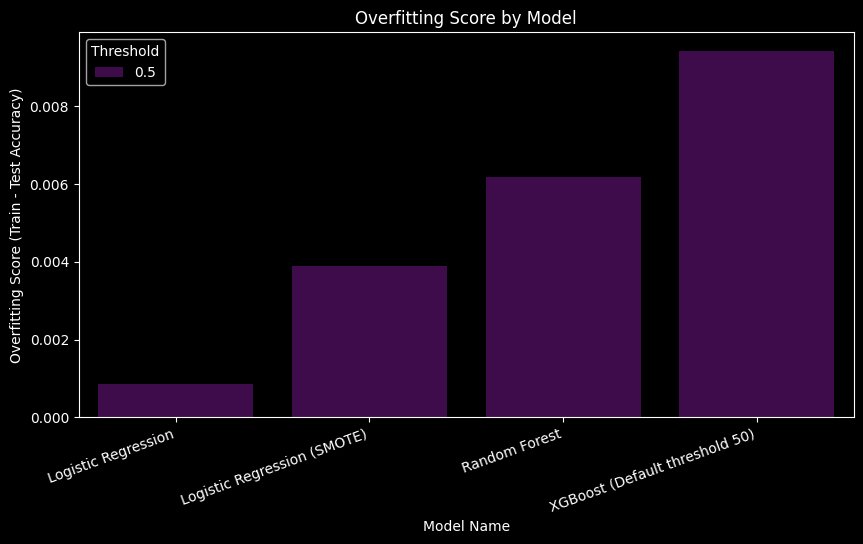

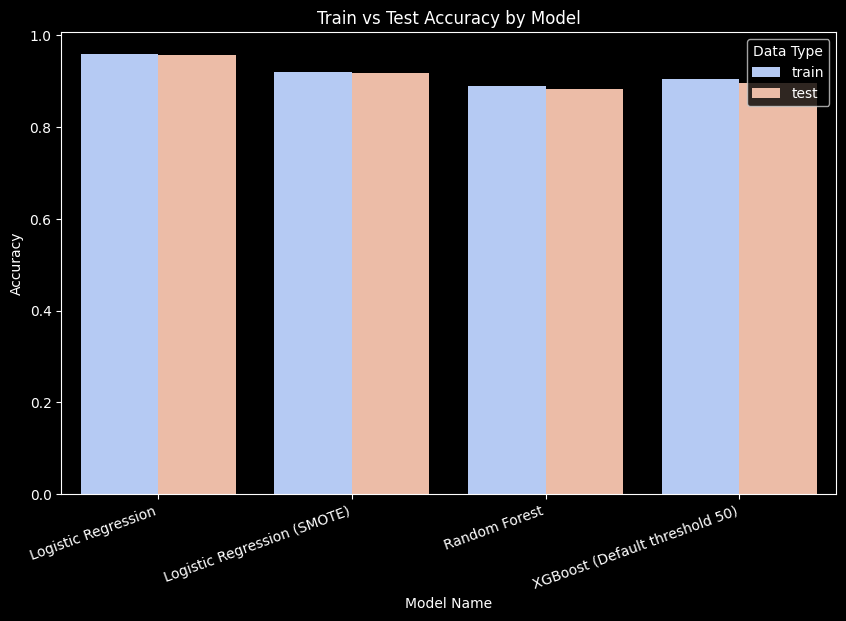

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results_pivot.reset_index(), x="model_name", y="overfitting_score", hue="threshold", palette="viridis")
plt.xlabel("Model Name")
plt.ylabel("Overfitting Score (Train - Test Accuracy)")
plt.title("Overfitting Score by Model")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Threshold")
plt.show()

plt.figure(figsize=(10, 6))
df_melted = df_results_pivot.reset_index().melt(id_vars=["model_name", "threshold"], 
                                                value_vars=["train", "test"],
                                                var_name="data_type", value_name="accuracy")

sns.barplot(data=df_melted, x="model_name", y="accuracy", hue="data_type", palette="coolwarm")
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.title("Train vs Test Accuracy by Model")
plt.legend(title="Data Type")
plt.show()

